# Project 2 - Part 1

## TODO

- LSTM only predicts 1s

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import tsfresh
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Exploratory Data Analysis

In [200]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

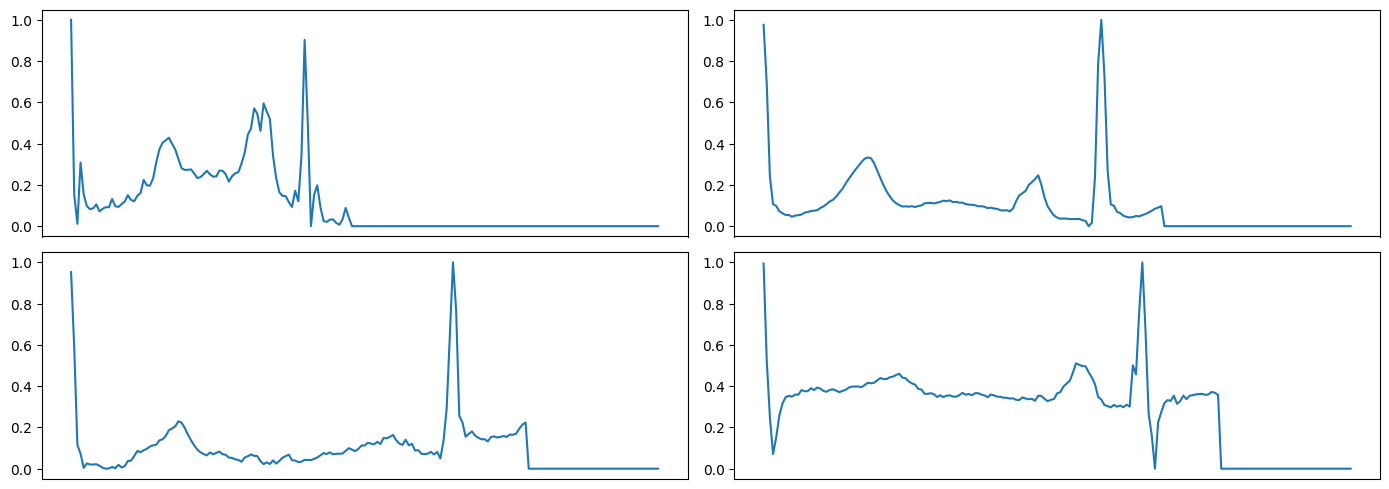

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

# Flatten the array for easy iteration
axs = axs.flatten()

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    axs[i].plot(X_train.iloc[i, :])
    
    # Set x ticks in 3 equidistant positions
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

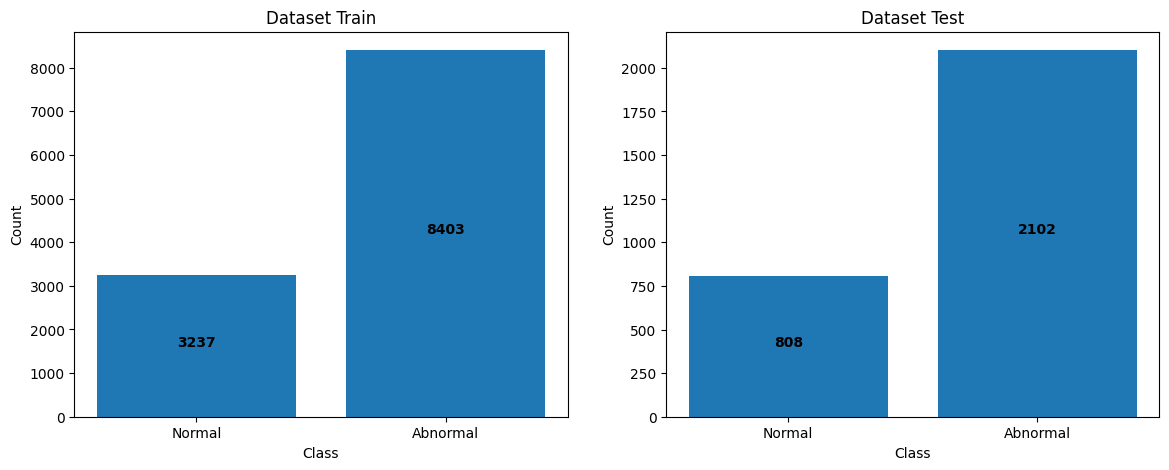

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(['Normal', 'Abnormal'], datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


In [5]:
n = len(y_train) + len(y_test)
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(len(datasets[i])/n*100) + '%')

Dataset Train: 80.0%
Dataset Test: 20.0%


In [6]:
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(np.mean(datasets[i])*100) + '%')

Dataset Train: 72.19072164948453%
Dataset Test: 72.23367697594502%


## Classic Machine Learning Methods

### Logistic Regression

In [8]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Train accuracy: ' + str(log_reg.score(X_train, y_train)))
print('Test accuracy: ' + str(log_reg.score(X_test, y_test)))

Train accuracy: 0.8344501718213059
Test accuracy: 0.8223367697594501


### Random Forest

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Train accuracy: ' + str(rf.score(X_train, y_train)))
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9670103092783505


### Feature Design

In [10]:
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

X_train_extended['mean'] = X_train.mean(axis=1)
X_train_extended['std'] = X_train.std(axis=1)
X_train_extended['median'] = X_train.median(axis=1)
X_train_extended['max'] = X_train.max(axis=1)
X_train_extended['min'] = X_train.min(axis=1)
X_train_extended['range'] = X_train.max(axis=1) - X_train.min(axis=1)
X_train_extended['iqr'] = X_train.quantile(0.75, axis=1) - X_train.quantile(0.25, axis=1)
X_train_extended['q1'] = X_train.quantile(0.25, axis=1)
X_train_extended['q3'] = X_train.quantile(0.75, axis=1)
X_train_extended['kurtosis'] = X_train.kurtosis(axis=1)
X_train_extended['skew'] = X_train.skew(axis=1)
X_test_extended['mean'] = X_test.mean(axis=1)
X_test_extended['std'] = X_test.std(axis=1)
X_test_extended['median'] = X_test.median(axis=1)
X_test_extended['max'] = X_test.max(axis=1)
X_test_extended['min'] = X_test.min(axis=1)
X_test_extended['range'] = X_test.max(axis=1) - X_test.min(axis=1)
X_test_extended['iqr'] = X_test.quantile(0.75, axis=1) - X_test.quantile(0.25, axis=1)
X_test_extended['q1'] = X_test.quantile(0.25, axis=1)
X_test_extended['q3'] = X_test.quantile(0.75, axis=1)
X_test_extended['kurtosis'] = X_test.kurtosis(axis=1)
X_test_extended['skew'] = X_test.skew(axis=1)

In [11]:
log_reg_extended = LogisticRegression(max_iter=1000)
log_reg_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(log_reg_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(log_reg_extended.score(X_test_extended, y_test)))

Train accuracy: 0.8384020618556701
Test accuracy: 0.8340206185567011


In [12]:
rf_extended = RandomForestClassifier()
rf_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(rf_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(rf_extended.score(X_test_extended, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9714776632302405


## Recurrent Neural Networks - LSTM

In [212]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        
        _hidden_size = hidden_size if not bidirectional else hidden_size * 2
        self.fc = torch.nn.Linear(_hidden_size,output_size)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                # Initialize weights with Xavier initialization
                init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zeros
                init.constant_(param, 0.0)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [213]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [203]:
input_size = 1  
hidden_size = 10
output_size = 1

In [204]:
model = LSTMModel(input_size, hidden_size, output_size, bidirectional=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [205]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

In [222]:
model.init_weights()
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses_training.append(loss.item())
    
    with torch.no_grad():
        train_outputs = (outputs > 0.5).float()
        epoch_accuracies_training.append((train_outputs == y_train_tensor).cpu().float().mean())
    
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    epoch_losses_testing.append(loss_test.item())
    
    with torch.no_grad():
        test_outputs = (output_test > 0.5).float()
        epoch_accuracies_testing.append((test_outputs == y_test_tensor).cpu().float().mean())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.6887
Epoch [20/1000], Loss: 0.6797
Epoch [30/1000], Loss: 0.6700
Epoch [40/1000], Loss: 0.6604
Epoch [50/1000], Loss: 0.6510
Epoch [60/1000], Loss: 0.6418
Epoch [70/1000], Loss: 0.6328
Epoch [80/1000], Loss: 0.6242
Epoch [90/1000], Loss: 0.6163
Epoch [100/1000], Loss: 0.6094
Epoch [110/1000], Loss: 0.6036
Epoch [120/1000], Loss: 0.5992
Epoch [130/1000], Loss: 0.5960
Epoch [140/1000], Loss: 0.5939
Epoch [150/1000], Loss: 0.5926
Epoch [160/1000], Loss: 0.5918
Epoch [170/1000], Loss: 0.5915
Epoch [180/1000], Loss: 0.5913
Epoch [190/1000], Loss: 0.5912
Epoch [200/1000], Loss: 0.5912
Epoch [210/1000], Loss: 0.5911
Epoch [220/1000], Loss: 0.5911
Epoch [230/1000], Loss: 0.5911
Epoch [240/1000], Loss: 0.5911
Epoch [250/1000], Loss: 0.5911
Epoch [260/1000], Loss: 0.5911
Epoch [270/1000], Loss: 0.5911
Epoch [280/1000], Loss: 0.5911
Epoch [290/1000], Loss: 0.5911
Epoch [300/1000], Loss: 0.5911
Epoch [310/1000], Loss: 0.5911
Epoch [320/1000], Loss: 0.5911
Epoch [330/1000],

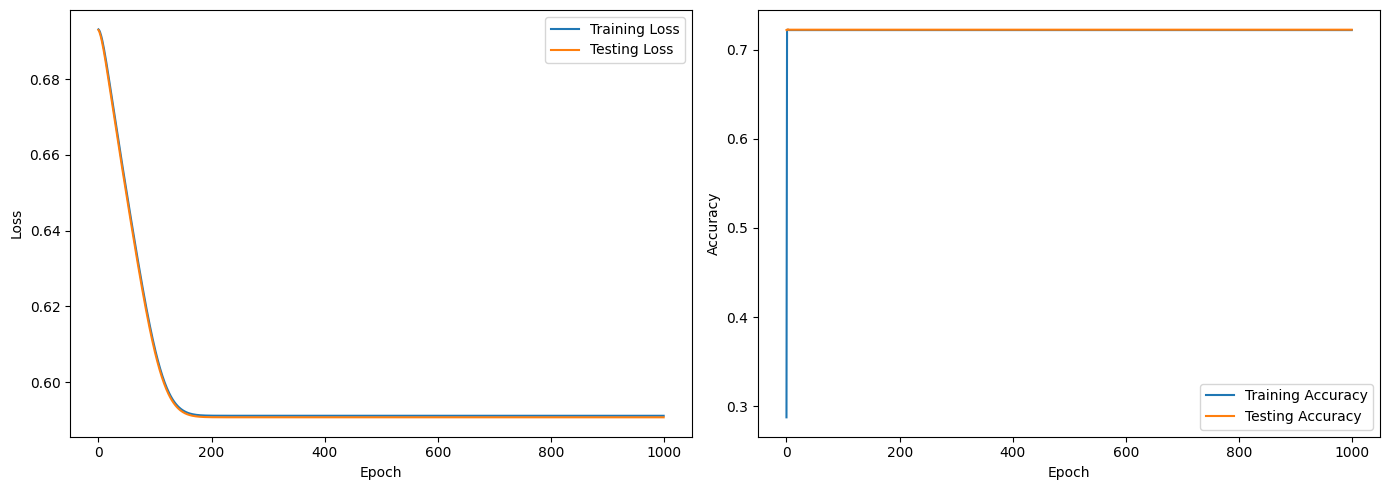

In [223]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [224]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')

tensor([[0.7219],
        [0.7219],
        [0.7219],
        ...,
        [0.7219],
        [0.7219],
        [0.7219]], device='mps:0')
Accuracy: 0.7223, Loss: 0.5907


In [231]:
for i in range(5):
    a = model(X_test_tensor[i, :, :].unsqueeze(0))
    print(a)

tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)


## Convolutional Neural Networks

## Attention and Transformers